## Initialization
To execute the model change the value of `path_to_dataset` with the path for the dataset folder.

In [ ]:
path_to_dataset = "/gdrive/My Drive/ANN challenges/data"

### Import libraries

In [ ]:
import os
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

keras = tf.keras
layers = tf.keras.layers
tf.__version__

'2.9.2'

In [ ]:
!pip install keras-cv
import keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Mount drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# Local folder of the original dataset
orig_data_dir = 'data_orig'

In [ ]:
os.system("rm -rf %s" % orig_data_dir)
os.system("cp -rf '%s' '%s'" % (path_to_dataset, orig_data_dir))

0

### Set seed for reproducibility

In [ ]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Utilities

In [ ]:
import zipfile

def zip_folder(folder='model'):
    zipf = zipfile.ZipFile(folder + '.zip', 'w', zipfile.ZIP_DEFLATED)
    zipdir(folder, zipf)
    zipf.close()

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

In [ ]:
# Return number of total items and a list of occurences for each class in the given dataset
def count_occurences(ds):
  count = 0
  occ = [0, 0, 0, 0, 0, 0, 0, 0]

  for x, y in ds:
      image, label = extract_image_and_label(x, y)
      occ[label] += 1
      count += 1
  return count, occ

In [ ]:
# Print information about the training and validation set
def get_dataset_details(ds, name="train_ds"):
  ds_count, ds_occ = count_occurences(ds)

  classes = []
  for i in range(8):
    classes.append(ds_occ[i])

  name = name.ljust(20)
  print(name, "Batches: %4d \t Total images: %5d \t Classes: " % (ds.cardinality().numpy(), ds_count), classes)

In [ ]:
# Create base directory structure for a dataset
def create_directories(base_path):
  os.mkdir(base_path + "/Species1")
  os.mkdir(base_path + "/Species2")
  os.mkdir(base_path + "/Species3")
  os.mkdir(base_path + "/Species4")
  os.mkdir(base_path + "/Species5")
  os.mkdir(base_path + "/Species6")
  os.mkdir(base_path + "/Species7")
  os.mkdir(base_path + "/Species8")

In [ ]:
# Extract image and label from a tensor
def extract_image_and_label(im, lb):
  im = im.numpy().astype("uint8")
  lb_ohe = lb.numpy()
  lb = np.where(lb_ohe==1)[0][0]
  return im, lb

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_callbacks(patience=10):

  callbacks = []

  # Early Stopping
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
def plot_loss_and_accuracy(history):
  plt.figure(figsize=(20,5))
  plt.plot(history.history['loss'], label='Training', alpha=.8, color='#ff7f0e')
  plt.plot(history.history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Binary Crossentropy')
  plt.grid(alpha=.3)

  plt.figure(figsize=(20,5))
  plt.plot(history.history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
  plt.plot(history.history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=.3)

  plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']

def plot_confusion_matrix(dataset, ds_type):
  actual = []
  predicted = []
  for x,y in dataset:
    y= tf.argmax(y,axis=1)
    actual.append(y)
    predicted.append(tf.argmax(model.predict(x, verbose=0),axis = 1))
    
  predicted = tf.concat(predicted, axis=0)
  actual = tf.concat(actual, axis=0)

  cm = tf.math.confusion_matrix(actual, predicted, num_classes=8)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

## Dataset split
The dataset given is composed by 3542 images. It is splitted in training and validation set accordingly to the percentage defined with `val_split`. The final result is saved inside the folder `split_data_dir`. We decided to create a custom split to have complete control on how the split process is executed.

In [ ]:
# Percentage of elements of training set used for validation
val_split = 0.1

### Read original dataset

In [ ]:
# Final folder for splitted dataset
split_data_dir = 'data_splitted'
split_train_dir = split_data_dir + "/train"
split_val_dir = split_data_dir + "/val"

In [ ]:
orig_ds = keras.utils.image_dataset_from_directory(
      orig_data_dir,
      batch_size=None,
      seed=seed,
      shuffle=True,
      image_size=(96, 96),
      labels='inferred',
      label_mode='categorical',
      class_names=None,
      color_mode='rgb',
      interpolation='bilinear',
      follow_links=False,
      crop_to_aspect_ratio=False
)

Found 3542 files belonging to 8 classes.


### Calculate split

In [ ]:
# Count number of elements in total and for each class of the training set
num_elems, train_occ = count_occurences(orig_ds)

train_occ

[186, 532, 515, 511, 531, 222, 537, 508]

In [ ]:
# Final number of elements for each class of the validation set
val_entries = []
for i in range(8):
  val_entries.append(int(train_occ[i] * val_split))

val_entries

[18, 53, 51, 51, 53, 22, 53, 50]

### Split the dataset

In [ ]:
# Clean splitted dataset folder
os.system("rm -rf " + split_data_dir)
os.mkdir(split_data_dir)

In [ ]:
train_ds_counts = [0, 0, 0, 0, 0, 0, 0, 0]
val_ds_counts = [0, 0, 0, 0, 0, 0, 0, 0]

# Create training directory and relative subdirs
train_path = split_train_dir
os.mkdir(train_path)
create_directories(train_path)

# Create validation directory and relative subdirs
val_path = split_val_dir
os.mkdir(val_path)
create_directories(val_path)

# Read all images and split them in validation and training sets
for x, y in orig_ds:
    im, lb = extract_image_and_label(x, y)

    # Check if there is still space in the validation set
    if val_ds_counts[lb] < val_entries[lb]:
      path = val_path
      val_ds_counts[lb] += 1
      n = val_ds_counts[lb]
      
    # Otherwise move the image to the training set
    else:
      path = train_path
      train_ds_counts[lb] += 1
      n = train_ds_counts[lb]

    path += "/Species%d/%.5d.jpg" % (lb + 1, n)
    keras.utils.save_img(path, im)

## Oversampling
In this section oversampling is done over the splitted training set. It is possible to define in `train_entries` the amount of images for each class of the final training set. Oversampling is made by replicating multiple times the same image. Advanced augmentation filters are applied on clones to make them different and to spare time during training.

https://www.tensorflow.org/tutorials/images/data_augmentation#two_options_to_use_the_keras_preprocessing_layers

In [ ]:
# Number of elements for each training class in the augmented dataset
train_entries = [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]

# Folder for augmented dataset
data_dir = "data"
train_dir = data_dir + "/train"
val_dir = data_dir + "/val"

### Import splitted dataset

In [ ]:
train_ds  = keras.utils.image_dataset_from_directory(
      split_train_dir,
      batch_size=None,
      seed=seed,
      shuffle=True,
      image_size=(96, 96),
      labels='inferred',
      label_mode='categorical',
      class_names=None,
      color_mode='rgb',
      interpolation='bilinear',
      follow_links=False,
      crop_to_aspect_ratio=False,
)

Found 3191 files belonging to 8 classes.


In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
      split_val_dir,
      batch_size=None,
      image_size=(96, 96),
      labels='inferred',
      label_mode='categorical',
      class_names=None,
      color_mode='rgb',
      interpolation='bilinear',
      follow_links=False,
      crop_to_aspect_ratio=False,
)

Found 351 files belonging to 8 classes.


In [ ]:
get_dataset_details(train_ds)
get_dataset_details(val_ds, name="val_ds")

train_ds             Batches: 3191 	 Total images:  3191 	 Classes:  [168, 479, 464, 460, 478, 200, 484, 458]
val_ds               Batches:  351 	 Total images:   351 	 Classes:  [18, 53, 51, 51, 53, 22, 53, 50]


### Data augmentation

In [ ]:
# https://keras.io/examples/vision/randaugment/#randaugment-for-image-classification-for-improved-robustness
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=0.5,
    seed=seed
)

In [ ]:
random_cutout = keras_cv.layers.preprocessing.RandomCutout(0.2, 0.2, seed=seed)
random_gridmask = keras_cv.layers.preprocessing.GridMask(seed=seed)

In [ ]:
def custom_preprocessing(x):
  x = tf.image.random_hue(x, 0.2, seed=seed)
  x = tf.image.random_saturation(x, 0.8, 1.2, seed=seed)
  x = random_cutout(x, training=True)

  # Apply gridmask randomly
  if random.random() <= 0.3:
    x = random_gridmask(x, training=True)

  # Apply rand_augment randomly
  if random.random() <= 0.3:
    x = rand_augment(x, training=True)

  return x

In [ ]:
advanced_data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", seed=seed),
  layers.RandomRotation(0.2, seed=seed),
  layers.RandomBrightness(0.2, seed=seed),
  layers.RandomContrast(0.2, seed=seed),
  layers.RandomZoom(0.1, seed=seed),
  layers.Lambda(lambda x: custom_preprocessing(x)),
])

### Examples of data augmentation

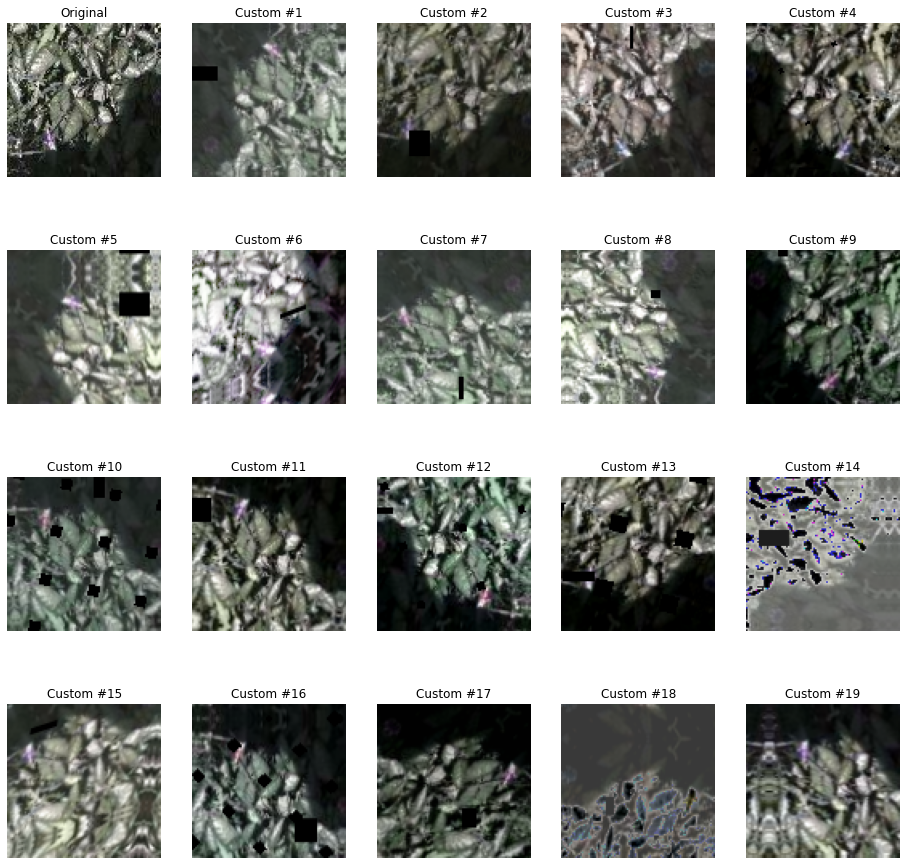

In [ ]:
# Read one image to show
for x, y in orig_ds:
  im, lb = extract_image_and_label(x, y)
  original = im
  break

# Plot the original and some versions of it with custom augmentation
plt.figure(figsize=(16, 16))
for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    if i == 0:
      plt.imshow(original, aspect='equal')
      plt.title("Original")
    else:
      im = advanced_data_augmentation(original, training=True)
      plt.imshow(np.uint8(im), aspect='equal')
      plt.title("Custom #%d" % i)
    plt.axis("off")

### Generate training set

In [ ]:
# Clean augmented dataset folder
os.system("rm -rf " + data_dir)
os.mkdir(data_dir)

In [ ]:
ids = [0, 0, 0, 0, 0, 0, 0, 0]

# Create training directory and relative subdirectories
os.mkdir(train_dir)
create_directories(train_dir)

# Count number of elements in total and for each class of the training set
num_elems, train_occ = count_occurences(train_ds)

# Calculate number of copies for each class based on the initial amount
classes_copies = {}
for i in range(8):
  classes_copies[i] = train_entries[i] / train_occ[i]

# Make each set of the given number of images
for x, y in train_ds:
  im, lb = extract_image_and_label(x, y)

  # Only for undersampling
  # Skip iteration if chosen images are already enough
  if ids[lb] > train_occ[lb]:
    continue
 
  # Save the original image
  ids[lb] += 1
  image_path = train_dir + "/Species%d/%.5d" % (lb + 1, ids[lb])
  path = image_path + ".jpg"
  keras.utils.save_img(path, im)

  j = 0

  # Save same image multiple times
  while(train_occ[lb] < train_entries[lb] and j < classes_copies[lb]):
    path = image_path + "_%.2d.jpg" % (j + 1)
    aug_im = advanced_data_augmentation(im, training=True)
    keras.utils.save_img(path, aug_im)

    train_occ[lb] += 1
    j += 1

In [ ]:
ids = [0, 0, 0, 0, 0, 0, 0, 0]

# Create validation set folder
os.mkdir(val_dir)
create_directories(val_dir)

# Save validation set
for x, y in val_ds:
  im, lb = extract_image_and_label(x, y)
  ids[lb] += 1
  path = val_dir + "/Species%d/%.5d.jpg" % (lb + 1, ids[lb])
  keras.utils.save_img(path, im)

### Check results

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
      data_dir + "/train",
      batch_size=None,
      seed=seed,
      shuffle=True,
      image_size=(96, 96),
      labels='inferred',
      label_mode='categorical',
      class_names=None,
      color_mode='rgb',
      interpolation='bilinear',
      follow_links=False,
      crop_to_aspect_ratio=False
)

Found 9600 files belonging to 8 classes.


In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
      data_dir + "/val",
      batch_size=None,
      seed=seed,
      shuffle=False,
      image_size=(96, 96),
      labels='inferred',
      label_mode='categorical',
      class_names=None,
      color_mode='rgb',
      interpolation='bilinear',
      follow_links=False,
      crop_to_aspect_ratio=False
)

Found 351 files belonging to 8 classes.


In [ ]:
get_dataset_details(train_ds)
get_dataset_details(val_ds, name="val_ds")

train_ds             Batches: 9600 	 Total images:  9600 	 Classes:  [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]
val_ds               Batches:  351 	 Total images:   351 	 Classes:  [18, 53, 51, 51, 53, 22, 53, 50]


## Transfer learning
Two training phases:
1. learning rate 1e-3 
2. learning rate 1e-4

https://www.tensorflow.org/tutorials/images/transfer_learning?hl=en

In [ ]:
# Batch size used for training
batch_size = 16

# Input shape for input layer
input_shape = (96, 96, 3)

### Import dataset for training

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
  directory=train_dir,
  batch_size=batch_size,
  seed=seed,
  image_size=(96, 96),
  color_mode='rgb',
  shuffle=True,
  labels='inferred',
  label_mode='categorical',
)

Found 9600 files belonging to 8 classes.


In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
  directory=val_dir,
  batch_size=batch_size,
  seed=seed,
  image_size=(96, 96),
  color_mode='rgb',
  shuffle=True,
  labels='inferred',
  label_mode='categorical',
)

Found 351 files belonging to 8 classes.


### Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Define the model

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape = input_shape
)

base_model.trainable = False

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", seed=seed),
  layers.RandomRotation(0.1, seed=seed),
  layers.RandomBrightness(0.1, seed=seed),
  layers.RandomContrast(0.1, seed=seed),
  layers.RandomZoom(0.1, seed=seed),
])

In [ ]:
inputs = keras.Input(shape=input_shape, name="input")
initializer = keras.initializers.GlorotUniform(seed)

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="top_avg_pool")(x)
x = layers.BatchNormalization(name="top_bn")(x)

x = layers.Dense(64, activation='softmax', name='dense_1', kernel_initializer=initializer)(x)
x = layers.Dropout(0.2, name="dense_1_dropout", seed=seed)(x)

outputs = layers.Dense(8, activation='softmax', name='output_layer', kernel_initializer=initializer)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.build(input_shape)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 sequential_10 (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-b0 (Function  (None, 3, 3, 1280)       5919312   
 al)                                                             
                                                                 
 top_avg_pool (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 top_bn (BatchNormalization)  (None, 1280)             5120      
                                                                 
 dense_1 (Dense)             (None, 64)                8198

### First training

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=create_callbacks(patience=15))

Epoch 1/100
600/600 [==============================] - 116s 180ms/step - loss: 1.9273 - accuracy: 0.3253 - val_loss: 1.7523 - val_accuracy: 0.4188
Epoch 2/100
600/600 [==============================] - 57s 96ms/step - loss: 1.7835 - accuracy: 0.3684 - val_loss: 1.6031 - val_accuracy: 0.5043
Epoch 3/100
600/600 [==============================] - 69s 115ms/step - loss: 1.6907 - accuracy: 0.4048 - val_loss: 1.4973 - val_accuracy: 0.5242
Epoch 4/100
600/600 [==============================] - 52s 87ms/step - loss: 1.6359 - accuracy: 0.4191 - val_loss: 1.3925 - val_accuracy: 0.5726
Epoch 5/100
600/600 [==============================] - 54s 90ms/step - loss: 1.5997 - accuracy: 0.4307 - val_loss: 1.2920 - val_accuracy: 0.6467
Epoch 6/100
600/600 [==============================] - 53s 89ms/step - loss: 1.5592 - accuracy: 0.4479 - val_loss: 1.2932 - val_accuracy: 0.6239
Epoch 7/100
600/600 [==============================] - 52s 86ms/step - loss: 1.5441 - accuracy: 0.4476 - val_loss: 1.2471 - val

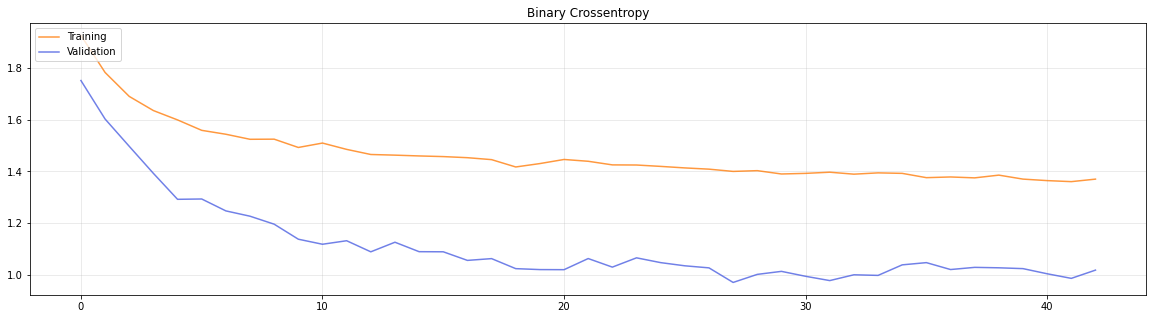

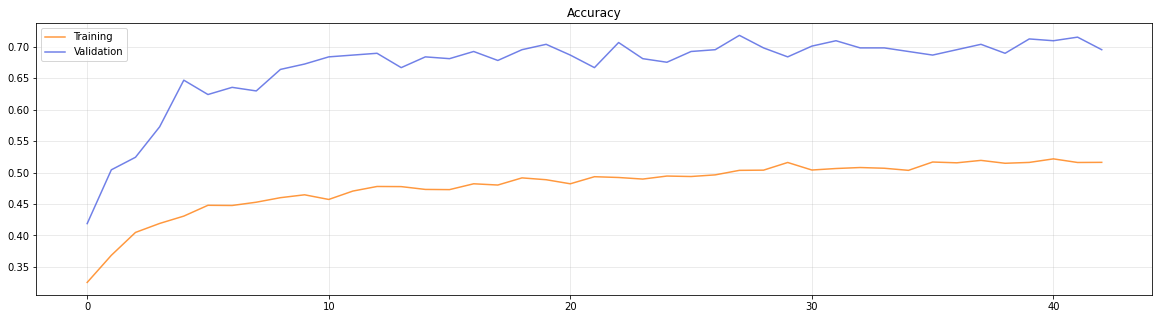

In [ ]:
plot_loss_and_accuracy(history)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
model.save('transfer_learning_model_1')

### Second training

In [ ]:
model = keras.models.load_model('transfer_learning_model_1')

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=create_callbacks(patience=10))

Epoch 1/100
600/600 [==============================] - 65s 94ms/step - loss: 1.3638 - accuracy: 0.5161 - val_loss: 0.9673 - val_accuracy: 0.7179
Epoch 2/100
600/600 [==============================] - 53s 89ms/step - loss: 1.3752 - accuracy: 0.5102 - val_loss: 0.9652 - val_accuracy: 0.7265
Epoch 3/100
600/600 [==============================] - 54s 90ms/step - loss: 1.3590 - accuracy: 0.5209 - val_loss: 0.9510 - val_accuracy: 0.7293
Epoch 4/100
600/600 [==============================] - 55s 93ms/step - loss: 1.3401 - accuracy: 0.5275 - val_loss: 0.9496 - val_accuracy: 0.7379
Epoch 5/100
600/600 [==============================] - 54s 90ms/step - loss: 1.3301 - accuracy: 0.5319 - val_loss: 0.9497 - val_accuracy: 0.7350
Epoch 6/100
600/600 [==============================] - 54s 89ms/step - loss: 1.3245 - accuracy: 0.5371 - val_loss: 0.9595 - val_accuracy: 0.7208
Epoch 7/100
600/600 [==============================] - 54s 90ms/step - loss: 1.3407 - accuracy: 0.5264 - val_loss: 0.9531 - val_ac

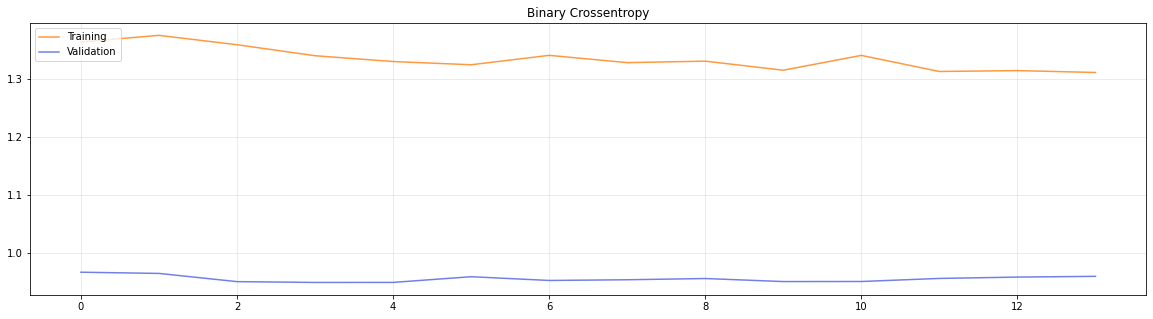

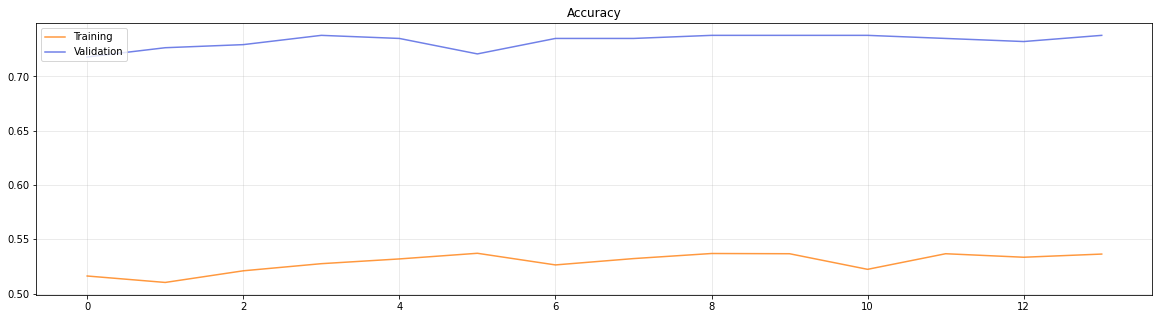

In [ ]:
plot_loss_and_accuracy(history)

In [ ]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

loss += history.history['loss']
val_loss += history.history['val_loss']

In [ ]:
model.save('transfer_learning_model_2')

## Fine tuning
Two training phases
1. Last 15 layers with learing rate 1e-5
2. Last 25 layers with learning rate 1e-6

### Import the model

In [ ]:
# Import transfer learning model
model =  keras.models.load_model('transfer_learning_model_2')

print("Number of layers in the base model: ", len(model.get_layer(base_model.name).layers))

# Enable base model training
model.get_layer(base_model.name).trainable = True

# Freeze all layers
for layer in model.get_layer(base_model.name).layers:
  layer.trainable = False

model.summary()

Number of layers in the base model:  270
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 sequential_10 (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-b0 (Function  (None, 3, 3, 1280)       5919312   
 al)                                                             
                                                                 
 top_avg_pool (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 top_bn (BatchNormalization)  (None, 1280)             5120      
                                                                 
 dense_1 (Dense)  

### First training

In [ ]:
# Unfreeze last layers except batch normalization
for layer in model.get_layer(base_model.name).layers[-25:]:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True
    
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 sequential_10 (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-b0 (Function  (None, 3, 3, 1280)       5919312   
 al)                                                             
                                                                 
 top_avg_pool (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 top_bn (BatchNormalization)  (None, 1280)             5120      
                                                                 
 dense_1 (Dense)             (None, 64)                8198

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=create_callbacks(patience=10))

Epoch 1/100
600/600 [==============================] - 64s 93ms/step - loss: 1.3183 - accuracy: 0.5342 - val_loss: 0.9537 - val_accuracy: 0.7265
Epoch 2/100
600/600 [==============================] - 54s 91ms/step - loss: 1.3313 - accuracy: 0.5265 - val_loss: 0.9528 - val_accuracy: 0.7350
Epoch 3/100
600/600 [==============================] - 56s 94ms/step - loss: 1.3147 - accuracy: 0.5344 - val_loss: 0.9361 - val_accuracy: 0.7379
Epoch 4/100
600/600 [==============================] - 54s 90ms/step - loss: 1.2997 - accuracy: 0.5415 - val_loss: 0.9350 - val_accuracy: 0.7464
Epoch 5/100
600/600 [==============================] - 54s 90ms/step - loss: 1.3164 - accuracy: 0.5370 - val_loss: 0.9325 - val_accuracy: 0.7464
Epoch 6/100
600/600 [==============================] - 54s 90ms/step - loss: 1.3088 - accuracy: 0.5442 - val_loss: 0.9505 - val_accuracy: 0.7322
Epoch 7/100
600/600 [==============================] - 56s 93ms/step - loss: 1.3231 - accuracy: 0.5347 - val_loss: 0.9407 - val_ac

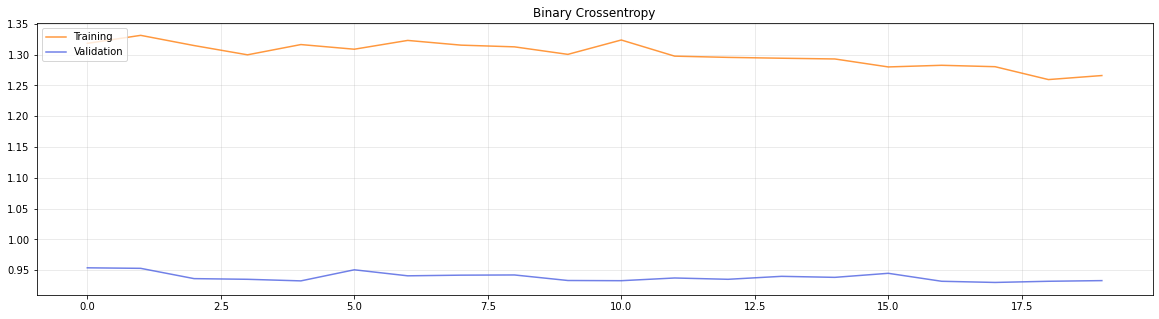

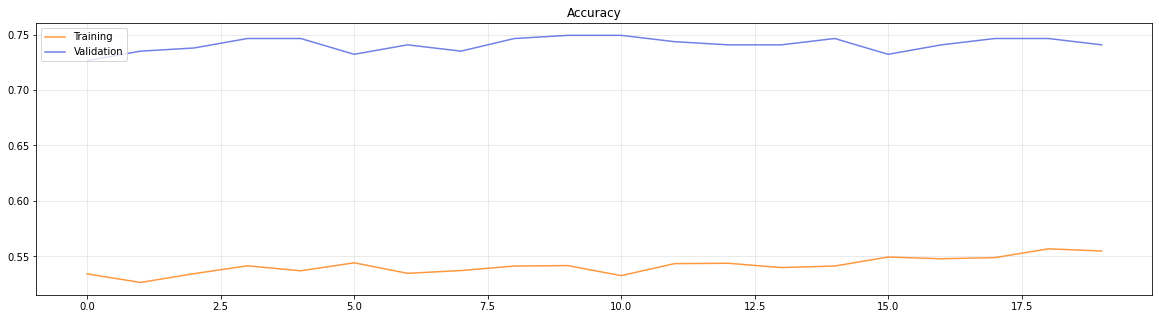

In [ ]:
plot_loss_and_accuracy(history)

In [ ]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

loss += history.history['loss']
val_loss += history.history['val_loss']

In [ ]:
model.save('fine_tuning_model_1')

### Second training

In [ ]:
model = keras.models.load_model('fine_tuning_model_1')

In [ ]:
# Unfreeze last layers except batch normalization
for layer in model.get_layer(base_model.name).layers[-35:]:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 sequential_10 (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-b0 (Function  (None, 3, 3, 1280)       5919312   
 al)                                                             
                                                                 
 top_avg_pool (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 top_bn (BatchNormalization)  (None, 1280)             5120      
                                                                 
 dense_1 (Dense)             (None, 64)                8198

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-6), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=create_callbacks(patience=10))

Epoch 1/100
600/600 [==============================] - 65s 94ms/step - loss: 1.2724 - accuracy: 0.5526 - val_loss: 0.9336 - val_accuracy: 0.7521
Epoch 2/100
600/600 [==============================] - 57s 94ms/step - loss: 1.2874 - accuracy: 0.5424 - val_loss: 0.9347 - val_accuracy: 0.7436
Epoch 3/100
600/600 [==============================] - 55s 91ms/step - loss: 1.2728 - accuracy: 0.5507 - val_loss: 0.9313 - val_accuracy: 0.7436
Epoch 4/100
600/600 [==============================] - 55s 92ms/step - loss: 1.2596 - accuracy: 0.5557 - val_loss: 0.9307 - val_accuracy: 0.7464
Epoch 5/100
600/600 [==============================] - 55s 92ms/step - loss: 1.2716 - accuracy: 0.5552 - val_loss: 0.9299 - val_accuracy: 0.7464
Epoch 6/100
600/600 [==============================] - 56s 93ms/step - loss: 1.2638 - accuracy: 0.5597 - val_loss: 0.9336 - val_accuracy: 0.7436
Epoch 7/100
600/600 [==============================] - 54s 90ms/step - loss: 1.2814 - accuracy: 0.5492 - val_loss: 0.9300 - val_ac

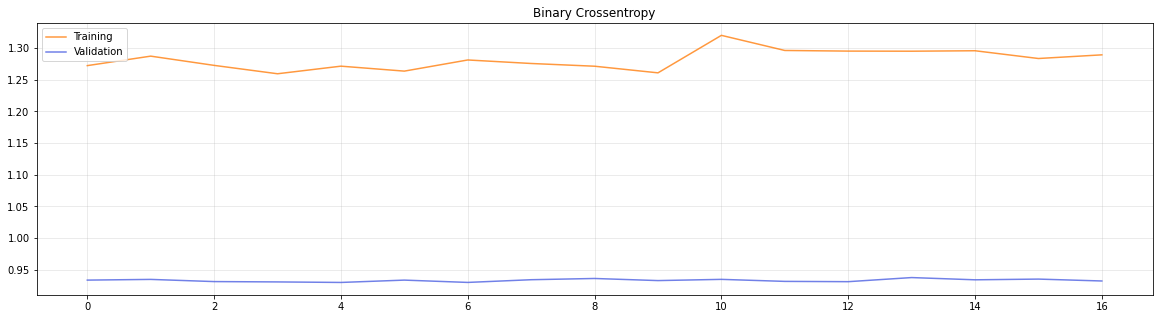

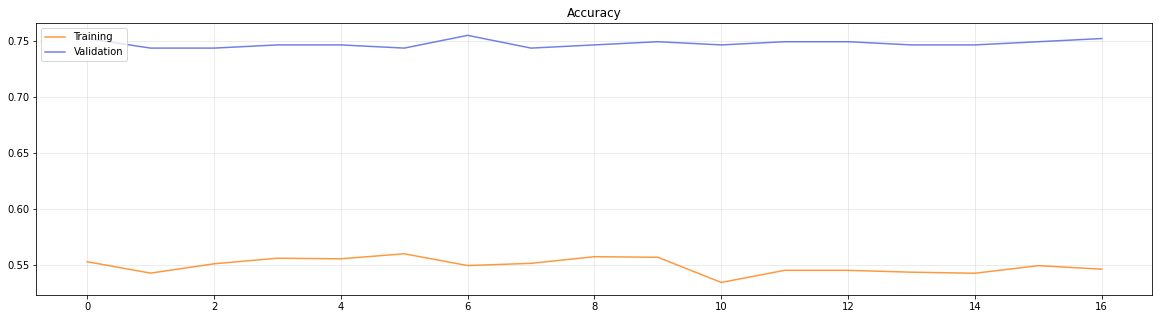

In [ ]:
plot_loss_and_accuracy(history)

In [ ]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

loss += history.history['loss']
val_loss += history.history['val_loss']

In [ ]:
model.save('fine_tuning_model_2')

### Results

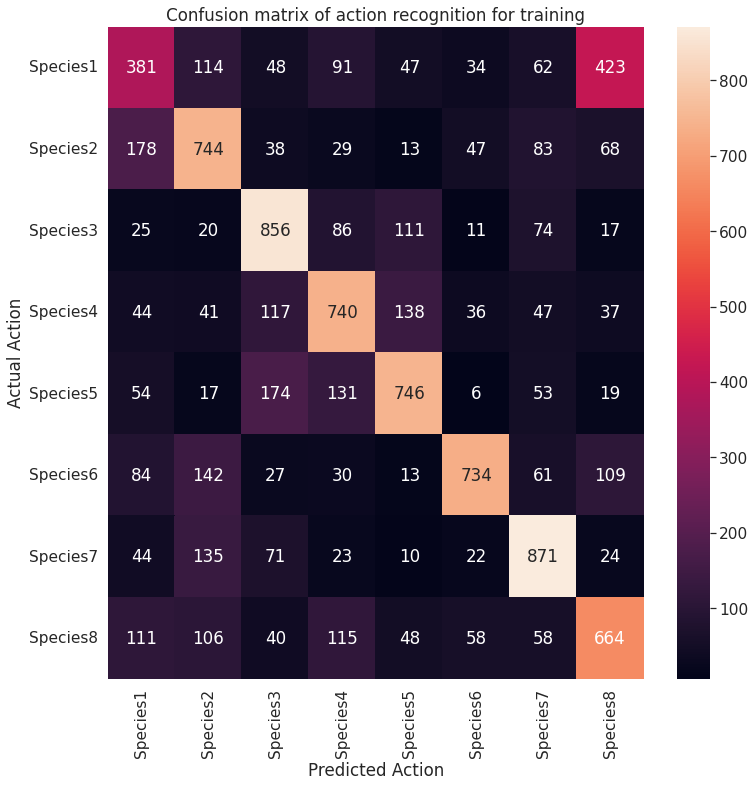

In [ ]:
plot_confusion_matrix(train_ds, ds_type="training")

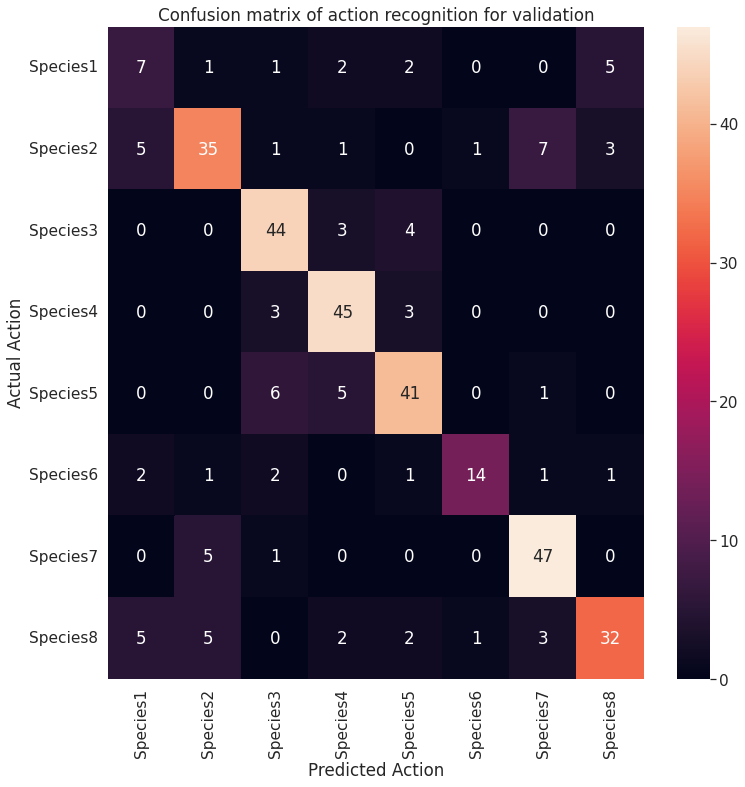

In [ ]:
plot_confusion_matrix(val_ds, ds_type="validation")

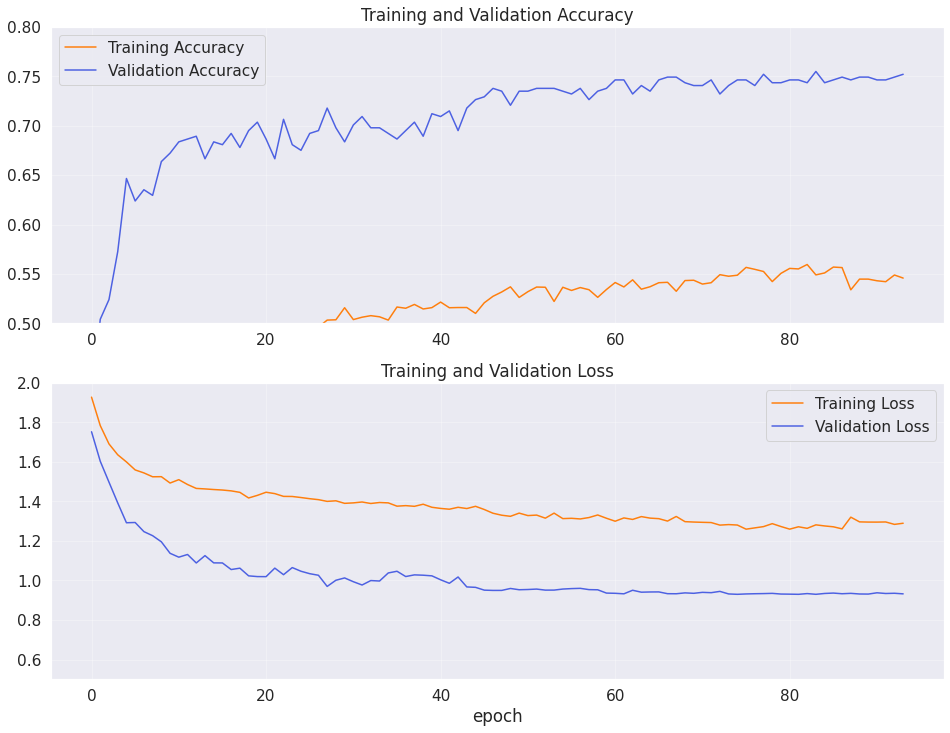

In [ ]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='#ff7f0e')
plt.plot(val_acc, label='Validation Accuracy', color='#4D61E2')
plt.ylim([0.5, 0.8])
plt.legend(loc='middle right')
plt.grid(alpha=.3)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='#ff7f0e')
plt.plot(val_loss, label='Validation Loss', color='#4D61E2')
plt.ylim([0.5, 2])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(alpha=.3)
plt.show()

In [ ]:
zip_folder('fine_tuning_model_2')

In [ ]:
del model
model = None